# Project Context

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:


The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

<Strong> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

# 1. Import Libraries

In [32]:
#pip install matplotlib
#pip install wordcloud
#pip install transformers
#pip install ipywidgets
#pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
#pip install tensorflow
#pip install tensorflow==2.12.0 (This version is more stable!!!!!)

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, TFAutoModel
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
import keras.backend as K

# 2. Data exploration

In [34]:
# Import data
train_df = pd.read_csv('C:/Users/TinyT/Downloads/Brandon HW2/train.csv',encoding='UTF-8')
test_df = pd.read_csv('C:/Users/TinyT/Downloads/Brandon HW2/test.csv',encoding='UTF-8')


### 2.1 Preview and check for NULL Values in train and test data

In [35]:
print('Train sample')
display(train_df.sample(5))
train_df.info()
print()
print()
print('Test sample')
display(test_df.sample(5))
test_df.info()

## CONCLUSION: There are no NULL values in text column for both train & test.

Train sample


,id,keyword,location,text,target
5666,8085,rescue,Karachi,Flood-zone : General Raheel Sharif visits Chit...,1
3025,4343,dust%20storm,NaN,Severe storm weakening as it moves SE towards ...,1
3390,4853,evacuation,"Portland, Ore.",New evacuation ordered for 25 homes in danger ...,1
3432,4908,explode,Winnipeg,I'm ready to explode! http://t.co/OwJe3i6yGN,0
2011,2887,damage,NaN,@WonderousAllure crosses her arms to cover her...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Test sample


,id,keyword,location,text
105,357,annihilation,"Yeezy Taught Me , NV",Please share and sign this petition to save wi...
69,228,airplane%20accident,New York,See how a judge ruled in this 2009 accident at...
1709,5770,forest%20fires,"Missoula, MT",Two New Bitterroot National Forest Fires are L...
1622,5457,first%20responders,"Cedar City, Utah",First Responders needed for a Cedar City commu...
1809,6121,hellfire,Beal Feirste Northern Ireland,@emmap645 @Vickygeex @Zak_Bagans @NickGroff_ @...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### 2.2 Check for duplicates

In [36]:
duplicates = train_df.duplicated(subset=['text'], keep=False)
sum(duplicates)
## CONCLUSION: There are 179 duplicates records, we will proceed to drop those.

179

In [37]:
# Drop duplicates in training
train_df.drop_duplicates(subset=['text'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


### 2.3 Check for class balance in train_df

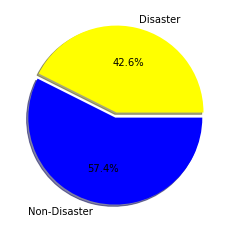

In [38]:
# Calculate disaster and non-disaster % in the df
disaster = round(train_df['target'].sum()/len(train_df),3)
non_disaster = round(1 - disaster,3)
# Set background color to white
plt.figure(facecolor='white')
# Plot pie chart
plt.pie(x=[disaster, non_disaster], labels=['Disaster', 'Non-Disaster'],explode=[0.03, 0.03], colors=['yellow', 'blue'], autopct='%1.1f%%', shadow=True, startangle=0)
# Show chart
plt.show()
## CONCLUSION: Class is balanced in the train_df.


### 2.4 Word Cloud

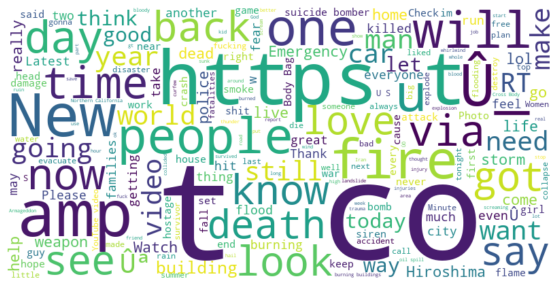

In [39]:
# Getting text_data 
text_data = ' '.join(train_df['text'])
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
## CONCLUSION: There are quite a few 'https' in the text, we will need to remove those as BERT preprocessing cannot take care of those.

### 2.5 More Data Exploration can be done on:
* Character length distritbution
* Sentence length distribution
* Location distribution [Might have potential language difference issue?]
* Key words frequency by disaster & non-disaster

# 3. Base Line Model

### 3.1 TBD

# 4. BERT Model

### 4.1 Text preprocessing

In [40]:
# Define text_preprocess functions
def text_preprocess(text):
    new_text = []
    for t in text.split(" "):
        # remove @metions
        t = '' if t.startswith('@') and len(t) > 1 else t
        # remove urls
        t = '' if t.startswith('http') else t
        # remove # from hashtag
        t = t.replace("#","")
        # set all words to lower case and append
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [41]:
# Apply text preprocessing function on train_df
train_df['clean_text'] = train_df['text'].apply(text_preprocess)
train_df.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


### 4.2 Tokenization

In [42]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [43]:
# Tokenizations [QUESTION 1: 这一步是不是还不算是embedding？]
SEQ_LEN = 30
train_tokenize_inputs = tokenizer(train_df['clean_text'].tolist(), add_special_tokens = True, padding = 'max_length', truncation = True, max_length = SEQ_LEN, return_token_type_ids = False, return_tensors = 'tf')
## QUESTION 2: 有没有不需要用add_special_tokens的情况？ Yes, it is possible to use BERT-like models without using the [CLS] and [SEP] tokens, but it may require some modifications to the model architecture and training process. 这里说的modifications老师有什么experience上的example吗？
train_dataset = tf.data.Dataset.from_tensor_slices((train_tokenize_inputs, train_df['target'].values))

In [44]:
# Define fucntion for data format required by BERT
def map_bert(inputs, labels):
    inputs = {'input_ids': inputs['input_ids'],
              'attention_mask': inputs['attention_mask']}
    return inputs, labels

In [45]:
# Apply function to prepare data into format suitable for BERT
train_dataset = train_dataset.map(map_bert)

### 4.3 Training & Validation Split

In [15]:
# Shuffle the dataset and split into batches with size of 16 and take 80% for train and 20% for validation
dataset = train_dataset.batch(64)
DS_LEN = len(dataset)
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

## In practice, common batch sizes for BERT models range from 16 to 128. However, the optimal batch size for your specific task may vary. 
## It's recommended to perform experiments with different batch sizes to see which one works best for your particular dataset and model architecture.
## Keep in mind that there is no one-size-fits-all answer, and the optimal batch size may require some experimentation and tuning.
## QUESTION 3: 这里如果在industry做project的时候需要写成一个function to optimize batch size吗？ 调整这个parameter带来的improvement会很大吗？

### 4.4 Model Desgin

In [46]:
# Fetch BERT model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [47]:
# Create input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# BERT embeddings
embeddings = bert(input_ids, attention_mask=mask)[0]
cls_token = embeddings[:,0,:]

# Keras layers
## In Keras, a "layer" refers to a fundamental building block in neural network architectures. 
## Each layer is responsible for performing a specific type of computation on its input data. 
## These computations can range from simple operations like matrix multiplications to more complex operations like convolutions or recurrent processing.
# Batch normalization layer
## Helps stabilize and speed up the training process. It normalizes the activations of a layer, ensuring they have a mean of 0 and standard deviation of 1.
x = tf.keras.layers.BatchNormalization()(cls_token)
# Dense layer
## 128 units. Each neuron in the layer is connected to every neuron in the previous and subsequent layers. It applies a linear transformation followed by an activation function to its inputs.
x = tf.keras.layers.Dense(128, activation='relu')(x)
# Dropout layer
## Used for regularization to prevent overfitting. This layer applies dropout regularization with a rate of 0.2, which means it randomly sets 20% of the input units to 0 during training.
x = tf.keras.layers.Dropout(0.2)(x)
# Dense layer
## Another fully connected layer with 32 units and ReLU activation.
x = tf.keras.layers.Dense(32, activation='relu')(x)

# Output layer 
## This is the output layer with 1 unit and a sigmoid activation function. This suggests that it's a binary classification problem, as the sigmoid activation function is commonly used for binary classification tasks.
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
bert_model_final = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [48]:
bert_model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                          

### 4.5 Model Training

In [49]:
# Define function to calculate f1_metric
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [50]:
# Define optimizer 
optimizer = Adam(learning_rate = 0.001)
# Define loss function
## This loss function is commonly used for binary classification tasks.
loss = BinaryCrossentropy()
# Complie model
bert_model_final.compile(optimizer = optimizer, loss = loss, metrics=['accuracy', f1_metric])

In [51]:
# Train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.001, monitor='val_loss')]

history = bert_model_final.fit(train_ds, validation_data = val_ds, epochs = 1) #callbacks = callbacks)

94/94 [==============================] - 425s 4s/step - loss: 0.7091 - accuracy: 0.5554 - f1_metric: 0.3836 - val_loss: 0.6810 - val_accuracy: 0.5804 - val_f1_metric: 0.0000e+00


In [ ]:
# evaluate on val data
bert_model_final.evaluate(val_ds)